In [14]:
import torch
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda

ds = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
    #target_transform=ToTensor()
)

In [15]:
print(ds[0][0].shape)

torch.Size([1, 28, 28])


In [16]:
import torch
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import cv2
import torchvision.transforms as transforms

def patchify(images: torch.Tensor, patch_dimension: int | tuple) -> torch.Tensor:
    N, c, h, w = images.shape

    unfold = torch.nn.Unfold(patch_dimension, stride=patch_dimension)

    return unfold(images).view(N, c, patch_dimension[0], patch_dimension[1], -1).permute(0, 4, 1, 2, 3)

#Test the patchify function
def plot_patches(tensor: torch.Tensor, patch_count: tuple[int, int]):
    fig = plt.figure(figsize=(8, 8))
    grid = ImageGrid(fig, 111, nrows_ncols=patch_count, axes_pad=0.1)

    for i, ax in enumerate(grid):
        patch = tensor[i].permute(1, 2, 0).numpy()
        patch = cv2.cvtColor(patch, cv2.COLOR_BGR2RGB)
        ax.imshow(patch)
        ax.axis('off')

    plt.show()

Dimension of image: torch.Size([1, 3, 600, 600])
torch.Size([1, 144, 3, 50, 50])
Size of patches: torch.Size([144, 3, 50, 50])


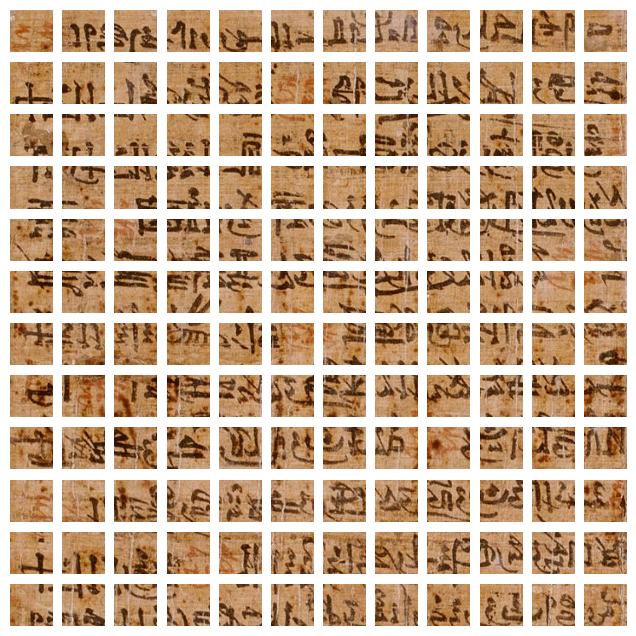

In [17]:
square_image = cv2.imread('data/test_patching/Squared_Papyrus_van_Ipoewer_600.jpg', cv2.COLOR_BGR2RGB)
square_image_tensor = transforms.ToTensor()(square_image)
square_image_tensor = square_image_tensor.unsqueeze(0)

#Shape is supposed to be N(batch), C, H, W
print(f"Dimension of image: {square_image_tensor.shape}")

square_patch_dimension = (50, 50)
square_patch_count = (12, 12)
square_as_patches = patchify(square_image_tensor, square_patch_dimension)
print(square_as_patches.shape)
square_as_patches = square_as_patches.squeeze(0)
print(f"Size of patches: {square_as_patches.shape}")
plot_patches(square_as_patches, square_patch_count)

torch.Size([1, 280, 3, 66, 64])


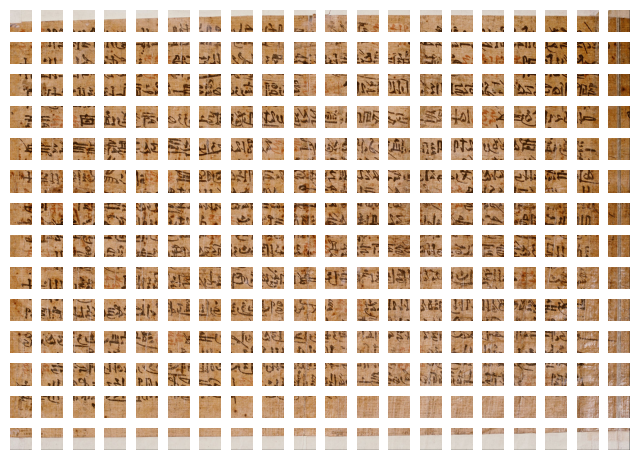

In [18]:
rectangle_image = cv2.imread('data/test_patching/Papyrus_van_Ipoewer_1280_924.jpg', cv2.COLOR_BGR2RGB)
rectangle_image_tensor = transforms.ToTensor()(rectangle_image)
rectangle_image_tensor = rectangle_image_tensor.unsqueeze(0)

rectangle_patch_dimension = (66, 64)
rectangle_patch_count = (14, 20)
rectangle_as_patches = patchify(rectangle_image_tensor, rectangle_patch_dimension)
print(rectangle_as_patches.shape)

rectangle_as_patches = rectangle_as_patches.squeeze(0)
plot_patches(rectangle_as_patches, rectangle_patch_count)

In [19]:
import torch.nn as nn
import numpy as np

#https://medium.com/mlearning-ai/vision-transformers-from-scratch-pytorch-a-step-by-step-guide-96c3313c2e0c

class VitEncoderBlock(nn.Module):
    mha: nn.MultiheadAttention
    n_heads: int
    hidden_d: int

    def __init__(self, hidden_d, n_heads, mlp_ratio=4):
        super().__init__()
        self.hidden_d = hidden_d
        self.n_heads = n_heads

        self.norm1 = nn.LayerNorm(hidden_d)
        self.mha = nn.MultiheadAttention(hidden_d, n_heads, batch_first=True)

        self.norm2 = nn.LayerNorm(hidden_d)
        self.mlp = nn.Sequential(
            nn.Linear(hidden_d, mlp_ratio * hidden_d),
            nn.GELU(),
            nn.Linear(mlp_ratio * hidden_d, hidden_d)
        )

    def forward(self, x):
        x = self.norm1(x)
        out = x + self.mha(x, x, x)[0]

        out = self.norm2(out)
        out = out + self.mlp(out)

        return out

class BasicVit(nn.Module):
  #For classification
  n_classes: int

  #For patchification
  dimensions_chw: tuple
  patch_dimensions: tuple[int, int]
  unfolder: torch.nn.Unfold

  #Encoder-related
  hidden_d: int
  n_blocks: int
  n_heads: int
  blocks: nn.ModuleList

  #Classification
  mlp: nn.Sequential

  def patchify(self, images: torch.Tensor) -> torch.Tensor:
    """Patchify an image - either square or rectangle"""
    return self.unfolder(images).permute(0, 2, 1)
  
  def init_unfolder(self):
    """Init the unfolder kernel"""
    self.unfolder = torch.nn.Unfold(self.patch_dimensions, stride=self.patch_dimensions)

  def get_positional_embeddings(self, sequence_length: int, dimension: int) -> torch.Tensor:
      result = torch.ones(sequence_length, dimension)
      for i in range(sequence_length):
          for j in range(dimension):
              result[i][j] = np.sin(i / (10000 ** (j / dimension))) if j % 2 == 0 else np.cos(i / (10000 ** ((j - 1) / dimension)))
      return result

  def __init__(self, dimensions_chw, patch_dimensions, hidden_dimension, n_classes,
              n_blocks = 2, n_heads = 2):
    # Super constructor
    super().__init__()

    self.hidden_d = hidden_dimension
    self.n_classes = n_classes
    self.n_blocks = n_blocks
    self.n_heads = n_heads

    # Channels, Height, Width
    self.dimensions_chw = dimensions_chw
    self.patch_dimensions = patch_dimensions

    #Init the unfolder for patchification
    self.init_unfolder()

    # The linear mapper has the flattened patch as input, so c*patch_dim
    c,h,w = self.dimensions_chw
    patch_col, patch_row = patch_dimensions
    self.input_d = int(c * patch_row * patch_col)
    self.linear_mapper = nn.Linear(self.input_d, self.hidden_d)

    # Learn v_class, the classification token
    self.class_token = nn.Parameter(torch.rand(1, self.hidden_d))

    batch_dimension = int((h/patch_col * w/patch_row) + 1)
    self.pos_embed = nn.Parameter(self.get_positional_embeddings(batch_dimension, self.hidden_d))
    self.pos_embed.requires_grad = False

    #Attention blocks
    self.blocks = nn.ModuleList([VitEncoderBlock(hidden_dimension, n_heads, 4) for i in range(n_blocks)])

    #Classification layer
    self.mlp = nn.Sequential(
            nn.Linear(self.hidden_d, n_classes),
            #nn.Softmax(dim=-1)
        )

  def forward(self, images):
    #Patchify the image batch and embed then through the linear layer
    print(images.shape)
    patches = self.patchify(images)
    embeding_patch_vectors = self.linear_mapper(patches)

    # Adding classification token to the tokens
    embeding_patch_vectors = torch.stack([torch.vstack((self.class_token, embeding_patch_vectors[i])) for i in range(len(embeding_patch_vectors))])
    
    # Add positional encoding
    n = embeding_patch_vectors.shape[0]
    pos_embed = self.pos_embed.repeat(n, 1, 1)
    out = embeding_patch_vectors + pos_embed

    #Now we have our embeddings, we pass them through our blocks
    for block in self.blocks:
       out = block(out)
    
    return self.mlp(out[:, 0])

# Now train it !

In [20]:
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor, Lambda
from torch.utils.data import DataLoader

transform = ToTensor()

train_set = MNIST(root='./../data', train=True, download=True, transform=transform, target_transform=Lambda(lambda y: torch.zeros(10, dtype=torch.float).scatter_(0, torch.tensor(y), value=1)))
test_set = MNIST(root='./../data', train=False, download=True, transform=transform, target_transform=Lambda(lambda y: torch.zeros(10, dtype=torch.float).scatter_(0, torch.tensor(y), value=1)))

train_loader = DataLoader(train_set, shuffle=True, batch_size=128)
test_loader = DataLoader(test_set, shuffle=False, batch_size=128)

In [21]:
print(f"Lenth of train: {len(train_loader.dataset)}") 
print(f"Lenth of test: {len(test_loader.dataset)}")

Lenth of train: 60000
Lenth of test: 10000


In [22]:
import torch
from torch.nn import CrossEntropyLoss, NLLLoss
from torch.optim import Adam
from tqdm import tqdm, trange

np.random.seed(0)
torch.manual_seed(0)

def main():
    # Defining model and training options
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print("Using device: ", device, f"({torch.cuda.get_device_name(device)})" if torch.cuda.is_available() else "")
    model = BasicVit(dimensions_chw=(1, 28, 28), patch_dimensions=(4, 4), hidden_dimension=20, n_blocks=2, n_heads=5, n_classes=10).to(device)
    
    N_EPOCHS = 50
    LR = 1e-3

    # Training loop
    optimizer = Adam(model.parameters(), lr=LR)
    criterion = CrossEntropyLoss()
    for epoch in trange(N_EPOCHS, desc="Training"):
        train_loss = 0.0
        for batch in tqdm(train_loader, desc=f"Epoch {epoch + 1} in training", leave=False):
            x, y = batch
            x, y = x.to(device), y.to(device)
            y_pred = model(x)
            loss = criterion(y_pred, y)

            train_loss += loss.detach().cpu().item() / len(train_loader)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
                    
        print(f"Epoch {epoch + 1}/{N_EPOCHS} loss: {train_loss:.2f}")

    # Test loop
    with torch.no_grad():
        correct, total = 0, 0
        test_loss = 0.0
        for batch in tqdm(test_loader, desc="Testing"):
            x, y = batch
            x, y = x.to(device), y.to(device)
            y_pred = model(x)
            loss = criterion(y_pred, y)
            test_loss += loss.detach().cpu().item() / len(test_loader)

            correct += torch.sum(torch.argmax(y_pred, dim=1) == torch.argmax(y, dim=1)).detach().cpu().item()
            total += len(x)
            
        print(f"Test loss: {test_loss:.2f}")
        print(f"Test accuracy: {correct / total * 100:.2f}%")

main()

Using device:  cuda (NVIDIA GeForce GTX 1650)


KeyboardInterrupt: 